In [ ]:
#export
from lab.imports import *

In [ ]:
# default_exp simulate.distribution

# Validate

Expose distribution tests for exploratory analysis.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

## Validating a Distribution

Sometimes I look at a variable, check for missing values, size, shape, and a few metrics. That's a good start to explore a variable. If I look a little deeper, I can check the distribution of the data, to see if it makes sense. It's a fun trick, and it can be useful. It comes at the danger of over-analyzing things.

But it also supports another thing I like to do, to create a baseline model that adds no real insight but gives me a point of comparison. Thisis how I look at machine learning--what good is it adding to something simple or obvious? Maybe it's a good idea to check if the distribution makes sense, if I have my wits about me before spending too much time building new tools.

It's a balancing act.

Either way, we can validate a distribution:

* plot: ...
* box plot: ...
* KS: ...
* Shapiro Wilk: ...
* The other: ...

And there's more too...

In [ ]:
#export
DEFAULT_VALIDATION_SIZE = 1000

def is_traditional_distribution(o):
    """A 'traditional' distribution has an `rvs`
    method attached, a tool for extracting random
    variables. Check if this is the case."""
    return hasattr(o, 'rvs')

def extract_values(o, *a, **kw):
    """Create a simple interface for either
    a distribution (e.g. `o.rvs(**kw)`) or a
    function (`o(**kw)`, or just an array-like
    object. (`np.array(o)`)."""
    if is_traditional_distribution(o): return np.array(o.rvs(*a, **kw))
    if callable(o): return np.array(o(*a, **kw))
    return np.array(o)

def extract_test_values(o, *a, **kw):
    """Offer test-sized values"""
    kw = {**{'size': DEFAULT_VALIDATION_SIZE}, **kw}
    return extract_values(o, *a, **kw)

The `is_traditional_distribution` looks for whether this is something from `scipy.stats` (meaning, it has an `rvs` method).

In [ ]:
assert is_traditional_distribution(stats.skewnorm)

## Extract Values

I like having top-level functions that hide the details of underlying code. The `extract_values` function will see if it can create random values from an `rvs` method. If it can't do that, it will call a function. If not, it will ensure the object is a NumPy array.

Also, there's a shortcut that suggests `DEFAULT_VALIDATION_SIZE` is a good sample size with `extract_test_values`.

In [ ]:
values = extract_values(stats.skewnorm, 5, size=3, loc=2, scale=0.001)
check_is_near(values, 2, atol=0.01)
dist = lambda *a, **kw: np.zeros(3) + 2
values = extract_values(dist)
check_equals(values, 2)
values = extract_values(np.zeros(3) + 1)
expected = [1,1,1]
check_equals(expected, values)

assert len(extract_test_values(stats.t, df=3) == DEFAULT_VALIDATION_SIZE)
assert len(extract_test_values(stats.t, df=3, size=3) == 3)

In [ ]:
#export
def plot_qq(o,
            *a,
            plot=None,
            display=True,
            alpha=0.2,
            **kw
           ):
    """Show how a distribution deviates from
    normal (scatter vs the line)"""

    if plot is None: plot = plt

    fig, ax = plot.subplots()
    x = extract_test_values(o, *a, **kw)
    res = stats.probplot(x, plot=plot)
    scatter, line = ax.get_lines()

    scatter.set_alpha(alpha / 4)
    scatter.set_marker('o')

    line.set_linewidth(4)
    line.set_alpha(alpha)

    fig.tight_layout()
    if display: plot.show()

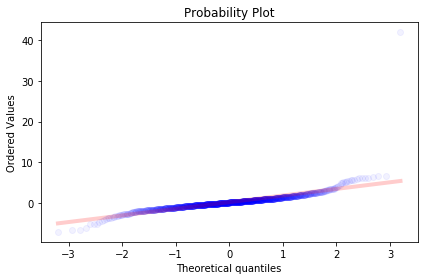

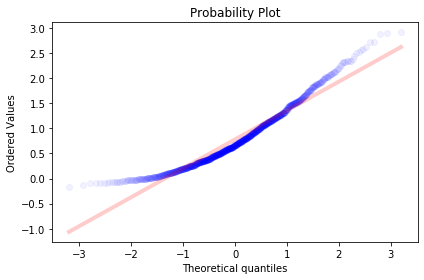

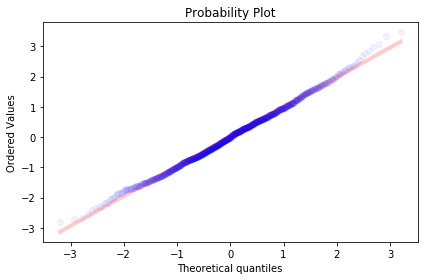

In [ ]:
plot_qq(stats.t, 3)
plot_qq(stats.skewnorm, a=10)
plot_qq(stats.norm)

In [ ]:
#export
def ideal_normal(o, bins, *a, **kw):
    """Create a plotable sequence that expresses
    the ideal normal probability distribution across
    a set of bins."""
    x = extract_test_values(o, *a, **kw)
    mu, sigma = np.mean(x), np.std(x)

    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

    return y

def plot_ditribution_vs_normal(o,
                               *a,
                               title='Distribution vs Normal',
                               num_bins=50,
                               **kw
                              ):
    """Show the difference between a distribution
    and an ideal normal distribution."""

    x = extract_test_values(o, *a, **kw)

    fig, ax = plt.subplots()

    _n, bins, _patches = ax.hist(x, num_bins, density=1, alpha=0.2)

    y = ideal_normal(x, bins)
    ax.plot(bins, y, '-')

    ax.set_ylabel('Probability Density')
    ax.set_yticks([], [])
    ax.set_title(title)
    fig.tight_layout()

    plt.show()

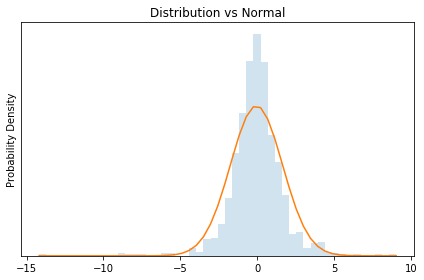

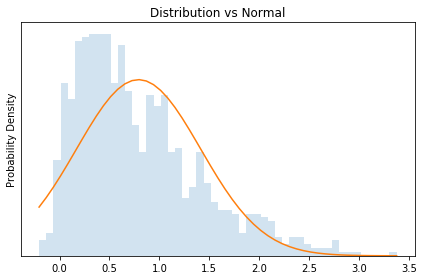

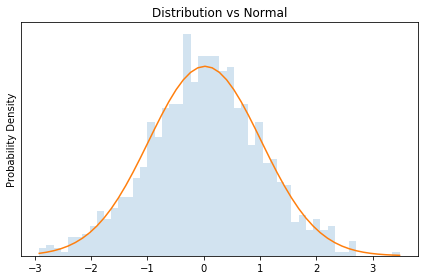

In [ ]:
plot_ditribution_vs_normal(stats.t, 3)
plot_ditribution_vs_normal(stats.skewnorm, a=10)
plot_ditribution_vs_normal(stats.norm)

Statistical validation can show me whether data fits a distrbution numerically.

In [ ]:
#export
def validate_with_shapiro_wilk(o, *a, accept=0.05, **kw):
    """Validate with the Shapiro-Wilk test..."""
    x = extract_test_values(o, *a, **kw)
    _w, p = stats.shapiro(x)
    return p >= accept

def validate_distribution(o, validator=validate_with_shapiro_wilk, **kw):
    """Validate a distribution generally, using Shapiro-Wilk as
    a default validation."""
    return validator(o, **kw)

In [ ]:
assert validate_with_shapiro_wilk(stats.norm)
with check_raises(message="Shapiro-Wilk should require at least 3 items to work."):
    validate_with_shapiro_wilk(stats.norm, size=2)
assert validate_distribution(stats.norm)

## Where Things Are

This is probably good enough for now. In the future, I could consider a few more things:

* wrap box plots that use this approach to data/distributions and formatting
* wrap and understand the Kolmogorov Smirnov test
* wrap and understand the Lilliefors test
* wrap and understand the Anderson-Darling test

I also have gotten behind on slips. I took many of these ideas from [this Medium article by Joos Korstanje
](https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93), though there are many flaws in that article. I also got information from [histogram featurs](https://matplotlib.org/3.1.1/gallery/statistics/histogram_features.html) and other Matplotib and scipy.stats documentation.